In [1]:
import pandas as pd
import numpy as np
from joblib import dump
import matplotlib.pyplot as plt
import pickle as pkl
import nltk
import re, string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.pipeline import Pipeline

In [2]:
from TextPreprocessor import TextPreprocessor        

In [3]:
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(tokenizer=nltk.TweetTokenizer().tokenize, 
                                   stop_words=(set(stopwords.words('english')).union(['4661', 'meeeeeeeeeeee', 'ja', '01457654035', 'reaally', '3624', '3904512441', 'mesooo', 'ان فرع', '']))
                                   )
    ),
    ('classifier', MLPClassifier(verbose=True, early_stopping=True))
])

TextPreprocessor initialized


In [4]:
ruta = "../data/SuicidiosProyecto.csv"
# ruta = "../data/pequenito.csv"
data = pd.read_csv(ruta, encoding="utf-8", index_col=0)

In [5]:
data.head()

,text,class
Unnamed: 0,,
173271,i want to destroy myselffor once everything wa...,suicide
336321,I kinda got behind schedule with learning for ...,non-suicide
256637,I'm just not sure anymoreFirst and foremost: I...,suicide
303772,please give me a reason to liveThats too much ...,suicide
293747,27f struggling to find meaning moving forwardI...,suicide


In [6]:
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size=0.3, random_state=28)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(136990,) (58710,) (136990,) (58710,)


In [7]:
pipeline.fit(x_train, y_train)

Fitting TextPreprocessor...
Transforming text...
Preprocessing text...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elpin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 10/10
Finished preprocessing text...


c:\Users\elpin\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ان', 'فرع'] not in stop_words.
  warnings.warn(


Iteration 1, loss = 0.23633557
Validation score: 0.934521
Iteration 2, loss = 0.13027898
Validation score: 0.933426
Iteration 3, loss = 0.09657392
Validation score: 0.930360
Iteration 4, loss = 0.07200270
Validation score: 0.926564
Iteration 5, loss = 0.05479055
Validation score: 0.925834
Iteration 6, loss = 0.04262225
Validation score: 0.922841
Iteration 7, loss = 0.03454399
Validation score: 0.921016
Iteration 8, loss = 0.02885853
Validation score: 0.920505
Iteration 9, loss = 0.02458472
Validation score: 0.918753
Iteration 10, loss = 0.02202198
Validation score: 0.916636
Iteration 11, loss = 0.01927752
Validation score: 0.916563
Iteration 12, loss = 0.01743446
Validation score: 0.917001
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words={'', '01457654035', '3624',
                                             '3904512441', '4661', 'a', 'about',
                                             'above', 'after', 'again',
                                             'against', 'ain', 'all', 'am',
                                             'an', 'and', 'any', 'are', 'aren',
                                             "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', ...},
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000001E33378DB80>>)),
                ('classifier',
                 MLPClassifier(early_stopping=True, verbose=True))])

In [8]:
pred_train = pipeline.predict(x_train)
pred_test = pipeline.predict(x_test)

Transforming text...
Preprocessing text...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elpin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 10/10
Finished preprocessing text...
Transforming text...
Preprocessing text...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elpin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Step 10/10
Finished preprocessing text...


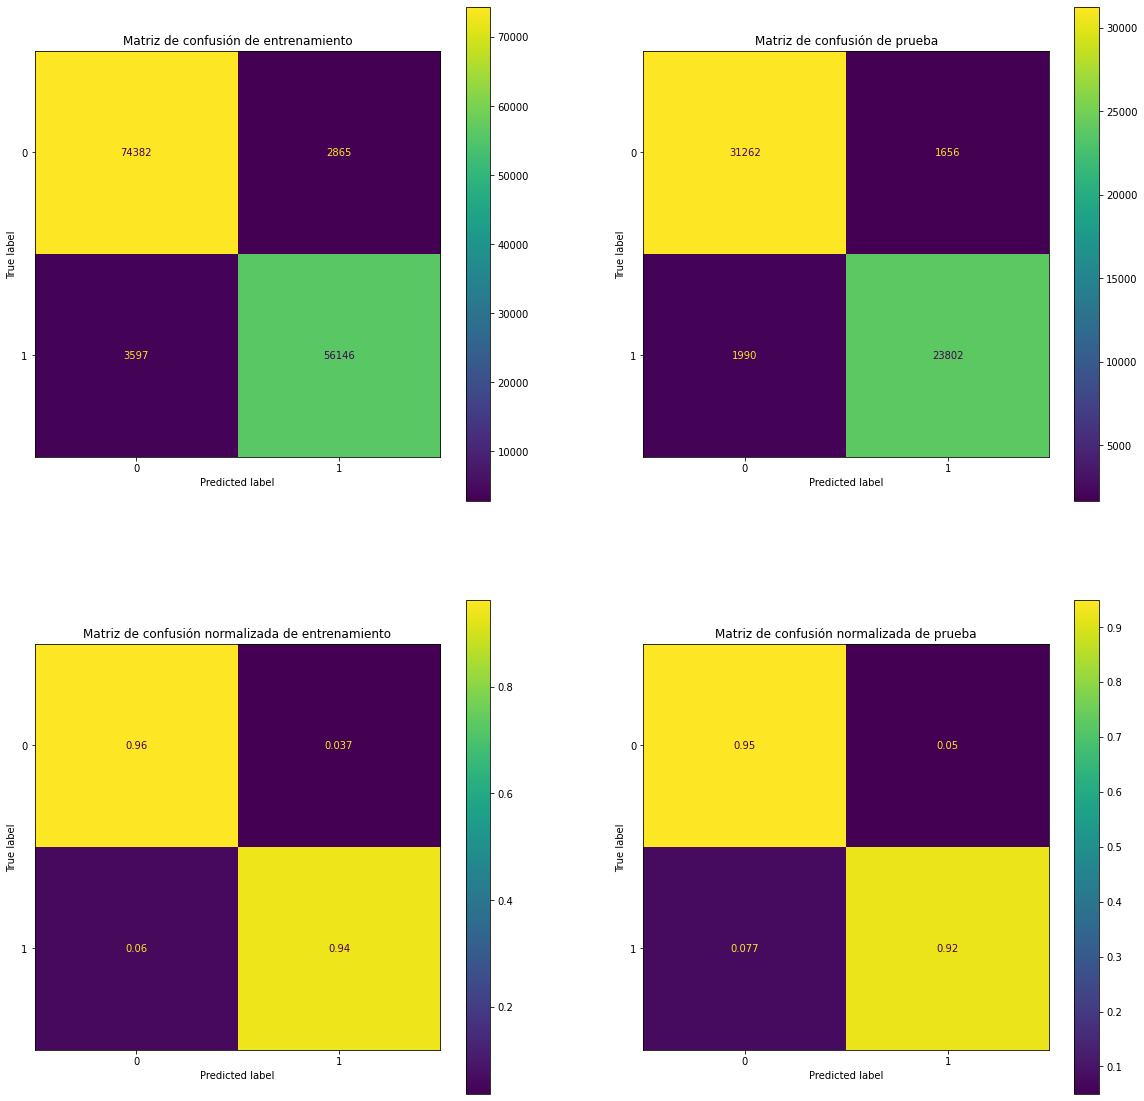

In [9]:
cm_train = confusion_matrix(y_train, pred_train)
cm_test = confusion_matrix(y_test, pred_test)
cm_train_norm = confusion_matrix(y_train, pred_train, normalize='true')
cm_test_norm = confusion_matrix(y_test, pred_test, normalize='true')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
ax[0, 0].set_title('Matriz de confusión de entrenamiento')
ax[0, 1].set_title('Matriz de confusión de prueba')
ax[1, 0].set_title('Matriz de confusión normalizada de entrenamiento')
ax[1, 1].set_title('Matriz de confusión normalizada de prueba')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_train_norm = ConfusionMatrixDisplay(confusion_matrix=cm_train_norm)
disp_test_norm = ConfusionMatrixDisplay(confusion_matrix=cm_test_norm)
disp_train.plot(ax=ax[0, 0])
disp_test.plot(ax=ax[0, 1])
disp_train_norm.plot(ax=ax[1, 0])
disp_test_norm.plot(ax=ax[1, 1])
plt.show()

In [10]:
rutaPipeline =  "pipeline.joblib"
dump(pipeline, rutaPipeline)

rutaPipeline =  "pipeline.pkl"
with open(rutaPipeline, 'wb') as file:
    pkl.dump(pipeline, file)